# TUMOR DETECTION & SEGMENTATION

Brain tumors include the most threatening types of tumors around the world.
Magnetic Resonance Imaging (MRI), a popular non-invasive strategy, produces a large and diverse number of tissue contrasts in each imaging modality and has been widely used by medical specialists to diagnose brain tumors2. However, the manual segmentation and analysis of structural MRI images of brain tumors is an arduous and time-consuming task which, thus far, can only be accomplished by professional neuroradiologists. Therefore, an automatic and robust brain tumor segmentation will have a significant impact on brain tumor diagnosis and treatment.

**Tumor Segmentation**

Tumor Segmentation is the task of identifying the spatial location of a tumor. It is a pixel-level prediction where each pixel is classified as a tumor or background. 

![](https://developer-blogs.nvidia.com/wp-content/uploads/2018/11/Screen-Shot-2018-11-26-at-8.36.35-PM.png)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from optuna.pruners import MedianPruner


import os
import glob
import random
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Image and Mask paths are already stored as a .csv File.
Root directory path is concatenated to each image/mask path in the dataframe.

Two important variables in the DataFrame:
* image_path
* mask_path

In [2]:
IMAGE_SIZE = (256, 256)

train_files = glob.glob('/kaggle/input/kits23-slices/slices/img/*.png')
mask_files = glob.glob('/kaggle/input/kits23-slices/slices/mask/*.png')

EPOCHS = 20
BATCH_SIZE = 8

In [3]:
def diagnosis(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                    "mask_path": mask_files,
                    "diagnosis": [diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,/kaggle/input/kits23-slices/slices/img/33-slic...,/kaggle/input/kits23-slices/slices/mask/33-sli...,1
1,/kaggle/input/kits23-slices/slices/img/12-slic...,/kaggle/input/kits23-slices/slices/mask/12-sli...,1
2,/kaggle/input/kits23-slices/slices/img/50-slic...,/kaggle/input/kits23-slices/slices/mask/50-sli...,1
3,/kaggle/input/kits23-slices/slices/img/17-slic...,/kaggle/input/kits23-slices/slices/mask/17-sli...,1
4,/kaggle/input/kits23-slices/slices/img/21-slic...,/kaggle/input/kits23-slices/slices/mask/21-sli...,1


	image_path	mask_path	diagnosis
0	/kaggle/input/kits23-slices/slices/img/33-slic...	/kaggle/input/kits23-slices/slices/mask/33-sli...	1
1	/kaggle/input/kits23-slices/slices/img/12-slic...	/kaggle/input/kits23-slices/slices/mask/12-sli...	1
2	/kaggle/input/kits23-slices/slices/img/50-slic...	/kaggle/input/kits23-slices/slices/mask/50-sli...	1
3	/kaggle/input/kits23-slices/slices/img/17-slic...	/kaggle/input/kits23-slices/slices/mask/17-sli...	1
4	/kaggle/input/kits23-slices/slices/img/21-slic...	/kaggle/input/kits23-slices/slices/mask/21-sli...	1

# Preprocessing of Image Data

In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.4)
df_test, df_val = train_test_split(df_train, test_size=0.5)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(23994, 3)
(11997, 3)
(11997, 3)


(23994, 3)
(11997, 3)
(11997, 3)

In [5]:
# Process the images by using the ImageDataGenerator of Keras library.
# A general function is created named create_generator, in which both images and masks are processed using flow_from_dataframe
# At the end of this function both image (img) and mask (msk) are normalized by dividing them by 255

def create_generator(df, aug_dict, image_size = (256, 256), batch_size = 32, seed = 42):
    
    IMG_SIZE = image_size
    BATCH_SIZE = batch_size
    SEED = seed

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
            df,
            class_mode = None,
            x_col = 'image_path',
            color_mode = 'rgb',
            target_size = IMG_SIZE,
            batch_size = BATCH_SIZE,
            save_prefix='image',
            seed = SEED)

    mask_generator = mask_datagen.flow_from_dataframe(
            df,
            class_mode = None,
            x_col = 'mask_path',
            color_mode = 'grayscale',
            target_size = IMG_SIZE,
            batch_size = BATCH_SIZE,
            save_prefix='mask',
            seed = SEED)

    generator = zip(image_generator, mask_generator)

    for (img,mask) in generator:
        img = img / 255
        msk = mask / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [6]:
# Data Augementation

train_aug_dict = dict(
    #rotation_range = 20,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    #zoom_range = 0.1,
    #horizontal_flip = True,
    #vertical_flip = True,
    fill_mode='nearest')

# These are the ready-to-use data for feeding into the deep neural networks

train_generator = create_generator(df_train, aug_dict = train_aug_dict)
validation_generator = create_generator(df_val, aug_dict = {})
test_generator = create_generator(df_test, aug_dict = {})

In [7]:
# Examining whether the data is generated correctly and their shapes are correct
# images should have the shape (256, 256, 3) and masks (256, 256, 1)
# images have a color mode of rgb (hence, 3 channels)
# masks have a color mode of grayscale (hence, 1 channel)

images, masks = next(train_generator)

# Check the number of images and masks
print(f"Number of images in the batch: {images.shape[0]}")
print(f"Shape of an image: {images.shape[1:]}")
print(f"Shape of a mask: {masks.shape[1:]}")

Found 23994 validated image filenames.
Found 23994 validated image filenames.
Number of images in the batch: 32
Shape of an image: (256, 256, 3)
Shape of a mask: (256, 256, 1)


Found 23994 validated image filenames.
Found 23994 validated image filenames.
Number of images in the batch: 32
Shape of an image: (256, 256, 3)
Shape of a mask: (256, 256, 1)

In [8]:
# Fixing the seed for random number generators

import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Evaluation Metrics

It is important to note that in medical image segmentation, accuracy is not a sufficient metric for evaluating the performance of the model. There are other metrices that the system should maximize during the training:

Dice coefficient = F1 score: a harmonic mean of precision and recall. In other words, it is calculated by 2*intersection divided by the total number of pixel in both images.

![](https://miro.medium.com/v2/resize:fit:440/format:webp/0*zwSd5AQdbUOcmLGH.png)

Jaccard Index (IoU) = Intersection over Union (IoU), is the area of the intersection over union of the predicted segmentation and the ground truth

![](https://miro.medium.com/v2/resize:fit:408/format:webp/0*TeYk75d83C7TkhD7.png)

It is highly recommended that Accuracy not to be used as evaluation metrics in image segmentation.
Instead, **dice coefficient** and **IoU** are the most commonly used metrics for semantic segmentation because both metrics **penalize false positives**, which is a common factor in highly class imbalanced datasets like MIS. However, choosing dice coefficient over IoU or vice versa is based on specific use cases of the task.


In [9]:
from tensorflow.keras.backend import sum, epsilon



smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

# DeepLabV3 Architeture

DeepLabv3 is a Deep Neural Network (DNN) architecture for Semantic Segmentation Tasks. It uses Atrous (Dilated) Convolutions to control the receptive field and feature map resolutions without increasing the total number of parameters. Another main attribute is something called Atrous Spatial Pyramid Pooling which effectively extracts multi-scale features that contain useful information for segmentation. In general, the network is able to capture dense feature maps with rich long-range information that can be used to accurately segment images.

**Atrous Convolution**
Atrous Convolution is the cornerstone of the DeepLab architecture. In atrous convolution, we just insert zeros into the convolution kernel to increase the size of the kernel without increasing the number of learnable parameters (because we don’t care about the zeros).

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*SVkgHoFoiMZkjy54zM_SUw.gif)

Atrous Convolution helps us construct a deeper network that retains more high level information at finer resolutions without increasing the number of parameters. 


**Atrous Spatial Pyramid Pooling**
If Atrous Convolution is the cornerstone then Atrous Spatial Pyramid Pooling (ASPP) is the foundation. Spatial Pyramid Pooling (SPP) resamples features at multiple scales and then pools them together (usually with an Average Pooling layer).

![](https://miro.medium.com/v2/resize:fit:502/format:webp/1*_czo1MY3oQeXx6XSF9i0yg.png)

In the case of ASPP, the feature scales are changed via Atrous Convolution rate. One thing to note with this, is that when the rate gets too large, the Atrous Convolution essentially becomes a 1x1 convolution. In this case, the rate is close to the size of the feature map and context from the entire image can not be captured. To overcome this problem, a 1x1 convolution is applied which retains the original feature map shape, and consequently obtains information from the entire feature map. The outputs are concatenated and Global Average Pooling is then applied.


The DeepLabv3 Architecture is composed of two main blocks: a backbone (Here, we us ResNet501) that is able to provide fine resolution feature maps via Atrous Convolution and a DeepLabv3 Head that is able to extract multi-scale features at a fine resolution, projects them to the desired number of feature maps (number of segmentation classes), and upsamples them to the input image resolution.

*Source: https://medium.com/@itberrios6/deeplabv3-c0c8c93d25a4*

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
NUM_CLASSES = 1


def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False, l2_reg = 0.001):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        kernel_regularizer=keras.regularizers.l2(l2_reg)
        )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(1, kernel_size=(1, 1), padding="same", activation='sigmoid')(x)
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    return model


model = DeeplabV3(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

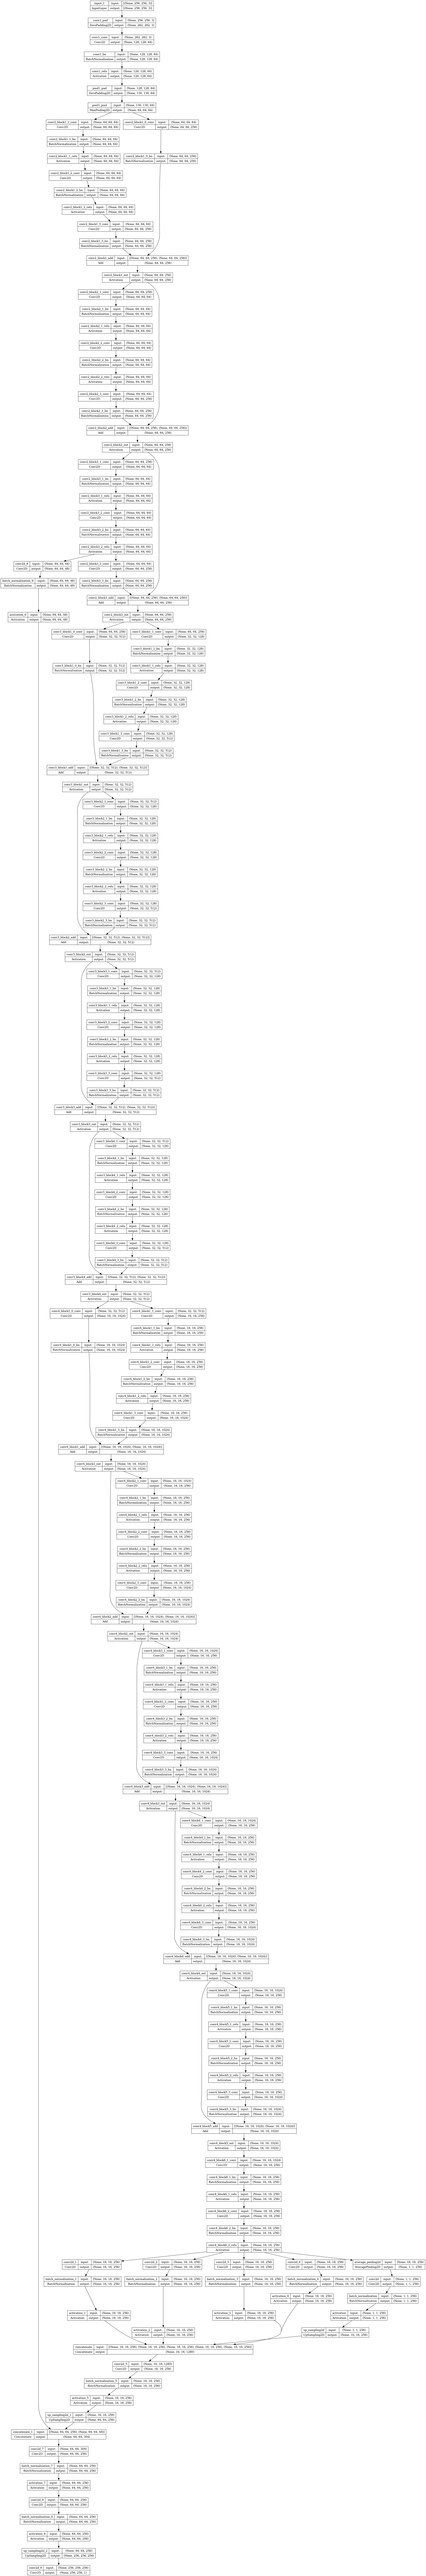

In [11]:
# Visualising the architecture of DeepLabV3

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=90,
    layer_range=None
)

# Hyperparamter Tuning

In oder to find the most optimal learning rate, Optuna library is used.
* 50 trials performed
* each trial with 30 Epochs
* MedianPruner is also used to skip those trials without promising results

*Note: Optuna section is very time-consuming and calcultion-intensive (it is skipped from this notebook)*

The results of Hyperparamter Tuning using Optuna:

***Best learning Rate: 0.0166047***

Narrowing down the range for finding the optimal learning rate.

**Learning Rate Optimization Result based on narrower range:**

learning rate: 0.01946688287114475

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import math  # Import math module for rounding functions

# Initialize the optimizer
opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

# Compile the model
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=["accuracy", iou, dice_coef])

# Create callbacks
callbacks = [
    ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

# Calculate the number of steps per epoch
steps_per_epoch = math.ceil(len(df_train) / BATCH_SIZE)

# Calculate the number of validation steps
validation_steps = math.ceil(len(df_val) / BATCH_SIZE)

# Fit the model
history_unet = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Save the model
model.save('TumorSeg_DeepLab_model.h5')


Epoch 1/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9979 - iou: 0.9248 - dice_coef: 0.9609Found 11997 validated image filenames.
Found 11997 validated image filenames.

Epoch 1: val_loss improved from inf to 0.05729, saving model to unet.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3000/3000 [==============================] - 1529s 499ms/step - loss: 0.0990 - accuracy: 0.9979 - iou: 0.9248 - dice_coef: 0.9609 - val_loss: 0.0573 - val_accuracy: 0.9979 - val_iou: 0.9247 - val_dice_coef: 0.9609 - lr: 1.0000e-04
Epoch 2/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9982 - iou: 0.9344 - dice_coef: 0.9660
Epoch 2: val_loss improved from 0.05729 to 0.04277, saving model to unet.hdf5
3000/3000 [==============================] - 1489s 496ms/step - loss: 0.0471 - accuracy: 0.9982 - iou: 0.9344 - dice_coef: 0.9660 - val_loss: 0.0428 - val_accuracy: 0.9983 - val_iou: 0.9364 - val_dice_coef: 0.9671 - lr: 1.0000e-04
Epoch 3/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9984 - iou: 0.9428 - dice_coef: 0.9706
Epoch 3: val_loss did not improve from 0.04277
3000/3000 [==============================] - 1481s 494ms/step - loss: 0.0383 - accuracy: 0.9984 - iou: 0.9428 - dice_coef: 0.9706 - val_loss: 0.0877 

Epoch 1/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9979 - iou: 0.9248 - dice_coef: 0.9609Found 11997 validated image filenames.
Found 11997 validated image filenames.

Epoch 1: val_loss improved from inf to 0.05729, saving model to unet.hdf5
/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
3000/3000 [==============================] - 1529s 499ms/step - loss: 0.0990 - accuracy: 0.9979 - iou: 0.9248 - dice_coef: 0.9609 - val_loss: 0.0573 - val_accuracy: 0.9979 - val_iou: 0.9247 - val_dice_coef: 0.9609 - lr: 1.0000e-04
Epoch 2/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9982 - iou: 0.9344 - dice_coef: 0.9660
Epoch 2: val_loss improved from 0.05729 to 0.04277, saving model to unet.hdf5
3000/3000 [==============================] - 1489s 496ms/step - loss: 0.0471 - accuracy: 0.9982 - iou: 0.9344 - dice_coef: 0.9660 - val_loss: 0.0428 - val_accuracy: 0.9983 - val_iou: 0.9364 - val_dice_coef: 0.9671 - lr: 1.0000e-04
Epoch 3/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9984 - iou: 0.9428 - dice_coef: 0.9706
Epoch 3: val_loss did not improve from 0.04277
3000/3000 [==============================] - 1481s 494ms/step - loss: 0.0383 - accuracy: 0.9984 - iou: 0.9428 - dice_coef: 0.9706 - val_loss: 0.0877 - val_accuracy: 0.9972 - val_iou: 0.9004 - val_dice_coef: 0.9475 - lr: 1.0000e-04
Epoch 4/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9984 - iou: 0.9427 - dice_coef: 0.9705
Epoch 4: val_loss improved from 0.04277 to 0.03473, saving model to unet.hdf5
3000/3000 [==============================] - 1484s 495ms/step - loss: 0.0381 - accuracy: 0.9984 - iou: 0.9427 - dice_coef: 0.9705 - val_loss: 0.0347 - val_accuracy: 0.9985 - val_iou: 0.9464 - val_dice_coef: 0.9724 - lr: 1.0000e-04
Epoch 5/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9986 - iou: 0.9489 - dice_coef: 0.9738
Epoch 5: val_loss improved from 0.03473 to 0.03283, saving model to unet.hdf5
3000/3000 [==============================] - 1482s 494ms/step - loss: 0.0329 - accuracy: 0.9986 - iou: 0.9489 - dice_coef: 0.9738 - val_loss: 0.0328 - val_accuracy: 0.9986 - val_iou: 0.9489 - val_dice_coef: 0.9738 - lr: 1.0000e-04
Epoch 6/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9986 - iou: 0.9480 - dice_coef: 0.9733
Epoch 6: val_loss improved from 0.03283 to 0.03172, saving model to unet.hdf5
3000/3000 [==============================] - 1490s 497ms/step - loss: 0.0336 - accuracy: 0.9986 - iou: 0.9480 - dice_coef: 0.9733 - val_loss: 0.0317 - val_accuracy: 0.9986 - val_iou: 0.9495 - val_dice_coef: 0.9741 - lr: 1.0000e-04
Epoch 7/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9987 - iou: 0.9529 - dice_coef: 0.9759
Epoch 7: val_loss improved from 0.03172 to 0.02970, saving model to unet.hdf5
3000/3000 [==============================] - 1479s 493ms/step - loss: 0.0300 - accuracy: 0.9987 - iou: 0.9529 - dice_coef: 0.9759 - val_loss: 0.0297 - val_accuracy: 0.9987 - val_iou: 0.9538 - val_dice_coef: 0.9764 - lr: 1.0000e-04
Epoch 8/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9987 - iou: 0.9543 - dice_coef: 0.9766
Epoch 8: val_loss improved from 0.02970 to 0.02919, saving model to unet.hdf5
3000/3000 [==============================] - 1483s 494ms/step - loss: 0.0291 - accuracy: 0.9987 - iou: 0.9543 - dice_coef: 0.9766 - val_loss: 0.0292 - val_accuracy: 0.9987 - val_iou: 0.9545 - val_dice_coef: 0.9767 - lr: 1.0000e-04
Epoch 9/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9988 - iou: 0.9561 - dice_coef: 0.9775
Epoch 9: val_loss did not improve from 0.02919
3000/3000 [==============================] - 1483s 495ms/step - loss: 0.0280 - accuracy: 0.9988 - iou: 0.9561 - dice_coef: 0.9775 - val_loss: 0.0303 - val_accuracy: 0.9987 - val_iou: 0.9529 - val_dice_coef: 0.9759 - lr: 1.0000e-04
Epoch 10/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9988 - iou: 0.9577 - dice_coef: 0.9784
Epoch 10: val_loss improved from 0.02919 to 0.02649, saving model to unet.hdf5
3000/3000 [==============================] - 1488s 496ms/step - loss: 0.0269 - accuracy: 0.9988 - iou: 0.9577 - dice_coef: 0.9784 - val_loss: 0.0265 - val_accuracy: 0.9989 - val_iou: 0.9582 - val_dice_coef: 0.9786 - lr: 1.0000e-04
Epoch 11/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9989 - iou: 0.9589 - dice_coef: 0.9790
Epoch 11: val_loss did not improve from 0.02649
3000/3000 [==============================] - 1478s 493ms/step - loss: 0.0262 - accuracy: 0.9989 - iou: 0.9589 - dice_coef: 0.9790 - val_loss: 0.0269 - val_accuracy: 0.9989 - val_iou: 0.9568 - val_dice_coef: 0.9779 - lr: 1.0000e-04
Epoch 12/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9988 - iou: 0.9555 - dice_coef: 0.9772
Epoch 12: val_loss did not improve from 0.02649
3000/3000 [==============================] - 1473s 491ms/step - loss: 0.0286 - accuracy: 0.9988 - iou: 0.9555 - dice_coef: 0.9772 - val_loss: 0.0273 - val_accuracy: 0.9988 - val_iou: 0.9573 - val_dice_coef: 0.9782 - lr: 1.0000e-04
Epoch 13/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9989 - iou: 0.9600 - dice_coef: 0.9796
Epoch 13: val_loss improved from 0.02649 to 0.02561, saving model to unet.hdf5
3000/3000 [==============================] - 1489s 496ms/step - loss: 0.0255 - accuracy: 0.9989 - iou: 0.9600 - dice_coef: 0.9796 - val_loss: 0.0256 - val_accuracy: 0.9989 - val_iou: 0.9593 - val_dice_coef: 0.9792 - lr: 1.0000e-04
Epoch 14/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9989 - iou: 0.9611 - dice_coef: 0.9802
Epoch 14: val_loss improved from 0.02561 to 0.02537, saving model to unet.hdf5
3000/3000 [==============================] - 1472s 491ms/step - loss: 0.0248 - accuracy: 0.9989 - iou: 0.9611 - dice_coef: 0.9802 - val_loss: 0.0254 - val_accuracy: 0.9989 - val_iou: 0.9599 - val_dice_coef: 0.9795 - lr: 1.0000e-04
Epoch 15/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9990 - iou: 0.9619 - dice_coef: 0.9806
Epoch 15: val_loss improved from 0.02537 to 0.02427, saving model to unet.hdf5
3000/3000 [==============================] - 1480s 494ms/step - loss: 0.0243 - accuracy: 0.9990 - iou: 0.9619 - dice_coef: 0.9806 - val_loss: 0.0243 - val_accuracy: 0.9990 - val_iou: 0.9621 - val_dice_coef: 0.9807 - lr: 1.0000e-04
Epoch 16/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9990 - iou: 0.9627 - dice_coef: 0.9810
Epoch 16: val_loss did not improve from 0.02427
3000/3000 [==============================] - 1474s 491ms/step - loss: 0.0238 - accuracy: 0.9990 - iou: 0.9627 - dice_coef: 0.9810 - val_loss: 0.0256 - val_accuracy: 0.9989 - val_iou: 0.9600 - val_dice_coef: 0.9796 - lr: 1.0000e-04
Epoch 17/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9989 - iou: 0.9604 - dice_coef: 0.9798
Epoch 17: val_loss improved from 0.02427 to 0.02335, saving model to unet.hdf5
3000/3000 [==============================] - 1476s 492ms/step - loss: 0.0254 - accuracy: 0.9989 - iou: 0.9604 - dice_coef: 0.9798 - val_loss: 0.0234 - val_accuracy: 0.9990 - val_iou: 0.9634 - val_dice_coef: 0.9814 - lr: 1.0000e-04
Epoch 18/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9990 - iou: 0.9641 - dice_coef: 0.9817
Epoch 18: val_loss did not improve from 0.02335
3000/3000 [==============================] - 1476s 492ms/step - loss: 0.0230 - accuracy: 0.9990 - iou: 0.9641 - dice_coef: 0.9817 - val_loss: 0.0240 - val_accuracy: 0.9990 - val_iou: 0.9622 - val_dice_coef: 0.9807 - lr: 1.0000e-04
Epoch 19/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9990 - iou: 0.9643 - dice_coef: 0.9818
Epoch 19: val_loss did not improve from 0.02335
3000/3000 [==============================] - 1470s 490ms/step - loss: 0.0229 - accuracy: 0.9990 - iou: 0.9643 - dice_coef: 0.9818 - val_loss: 0.0236 - val_accuracy: 0.9990 - val_iou: 0.9633 - val_dice_coef: 0.9813 - lr: 1.0000e-04
Epoch 20/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9990 - iou: 0.9650 - dice_coef: 0.9822
Epoch 20: val_loss did not improve from 0.02335
3000/3000 [==============================] - 1483s 494ms/step - loss: 0.0224 - accuracy: 0.9990 - iou: 0.9650 - dice_coef: 0.9822 - val_loss: 0.0235 - val_accuracy: 0.9990 - val_iou: 0.9638 - val_dice_coef: 0.9816 - lr: 1.0000e-04

In [15]:
def format_scores(score_list):
    return {'Loss': score_list[0], 'IoU': score_list[1], 
            'Binary Accuracy': score_list[2], 'Dice Coefficient': score_list[3]}

train_score = model.evaluate(train_generator, steps=steps_per_epoch, verbose=1)
valid_score = model.evaluate(validation_generator, steps=validation_steps, verbose=1)
test_score = model.evaluate(test_generator, steps=len(df_test) // BATCH_SIZE, verbose=1)

df_scores = pd.DataFrame({
    'Train': format_scores(train_score),
    'Validation': format_scores(valid_score),
    'Test': format_scores(test_score)
}).transpose()

df_scores

1500/1500 [==============================] - 259s 173ms/step - loss: 0.0235 - accuracy: 0.9990 - iou: 0.9638 - dice_coef: 0.9816
Found 11997 validated image filenames.
Found 11997 validated image filenames.
1499/1499 [==============================] - 250s 167ms/step - loss: 0.0233 - accuracy: 0.9990 - iou: 0.9642 - dice_coef: 0.9818


,Loss,IoU,Binary Accuracy,Dice Coefficient
Train,0.023369,0.999002,0.964019,0.981675
Validation,0.023460,0.999006,0.963816,0.981571
Test,0.023255,0.999000,0.964249,0.981794


3000/3000 [==============================] - 517s 172ms/step - loss: 0.0234 - accuracy: 0.9990 - iou: 0.9640 - dice_coef: 0.9817
1500/1500 [==============================] - 259s 173ms/step - loss: 0.0235 - accuracy: 0.9990 - iou: 0.9638 - dice_coef: 0.9816
Found 11997 validated image filenames.
Found 11997 validated image filenames.
1499/1499 [==============================] - 250s 167ms/step - loss: 0.0233 - accuracy: 0.9990 - iou: 0.9642 - dice_coef: 0.9818
Loss	IoU	Binary Accuracy	Dice Coefficient
Train	0.023369	0.999002	0.964019	0.981675
Validation	0.023460	0.999006	0.963816	0.981571
Test	0.023255	0.999000	0.964249	0.981794

custom_objects = {
    'dice_coef_loss': dice_coef_loss,
    'iou': iou,
    'dice_coef': dice_coef
}

loaded_model = load_model('/kaggle/input/deeplabv-model/TumorSeg_DeepLab_model.h5',
                         custom_objects= custom_objects)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def create_colored_mask(mask, thresholds, colors):
    # Initialize an empty mask with 3 channels
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Assign colors based on thresholds
    for i, threshold in enumerate(thresholds):
        mask_region = (mask > threshold) if i == 0 else ((mask > threshold) & (mask <= thresholds[i-1]))
        colored_mask[mask_region] = colors[i]

    return colored_mask

def plot_images_with_masks(test_df, model, num_images=3, thresholds=[0.5, 0.3, 0.1], colors=[[255, 0, 0], [255, 165, 0], [0, 128, 0]]):
    # Ensure num_images does not exceed the number of rows in test_df
    num_images = min(num_images, len(test_df))
    
    if num_images == 0:
        print("No images available to plot.")
        return

    fig, axes = plt.subplots(num_images, 4, figsize=(16, num_images * 4))
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure axes is 2D

    for i in range(num_images):
        # Load and preprocess the image
        img_path = test_df['image_path'].iloc[i]
        mask_path = test_df['mask_path'].iloc[i]
        img = load_img(img_path, target_size=(256, 256))
        mask = load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        img_preprocessed = np.expand_dims(img_array, axis=0)
        
        # Predict the mask
        predicted_mask = model.predict(img_preprocessed)[0]

        # Debug print: check the range of values in the predicted mask
        print(f"Predicted mask {i} - min: {predicted_mask.min()}, max: {predicted_mask.max()}")

        red_mask = create_colored_mask(predicted_mask.squeeze(), thresholds, colors)

        # Plot original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Plot real mask + image
        axes[i, 1].imshow(img)
        axes[i, 1].imshow(mask, cmap='gray', alpha=0.4)
        axes[i, 1].set_title('Real Mask + Image')
        axes[i, 1].axis('off')
        
        # Plot predicted raw mask
        axes[i, 2].imshow(predicted_mask.squeeze(), cmap='gray')
        axes[i, 2].set_title('Predicted Raw Mask')
        axes[i, 2].axis('off')
        
        # Plot predicted red mask + image
        axes[i, 3].imshow(img)
        axes[i, 3].imshow(red_mask, alpha=0.4)
        axes[i, 3].set_title('Predicted Red Mask + Image')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
filtered_df = df_test[df_test['diagnosis'] == '1']
plot_images_with_masks(filtered_df, model, num_images=6)
